## Calibration Plots CIL
Obtain calibration plots for the CIL \
Author: Clara Hoffmann 

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import multiprocessing
from scipy import integrate
from tqdm import tqdm
from helpers import find_closest_element
from scipy.stats import norm

In [2]:
# read in val data
path_all_imgs = '../../../../commaai_code/02_write_shards_optional/cil_shards/df_paths.csv'
all_img_df = pd.read_csv(path_all_imgs)
all_img_df = all_img_df[np.abs(all_img_df['true_y']) < 40].reset_index()
true_y = all_img_df['true_y']

density_path = '../../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)

In [3]:
# estimate density 
kde = sm.nonparametric.KDEUnivariate(true_y)
kde.fit()
support = kde.support
endog = kde.endog
density_gauss = kde.density
no_points = 750
grid = np.linspace(min(density['axes']), max(density['axes']), no_points)

In [14]:
# read in cdf_i for validation observations
va_ridge_av_den = np.load('../../../../data/commaai/calibration/cil_dens/va_ridge_av_dens.npy')
hmc_ridge_av_den = np.load('../../../../data/commaai/calibration/cil_dens/hmc_ridge_av_dens.npy')
va_horse_av_den = np.load('../../../../data/commaai/calibration/cil_dens/va_horse_av_dens.npy')
hmc_horse_av_den = np.load('../../../../data/commaai/calibration/cil_dens/hmc_horse_av_dens.npy')

In [5]:
density_mdn = np.load('../../../../data/commaai/predictions/density_cil_mdn.npy')
mdn_av_dens = np.mean(density_mdn, axis = 0)

In [6]:
mc_dropout_den = np.load('../../../../data/commaai/predictions/mc_dropout/density_dropout_cil.npy')
mc_dropout_av_dens = np.mean(mc_dropout_den, axis = 0)

## Marginal Calibration

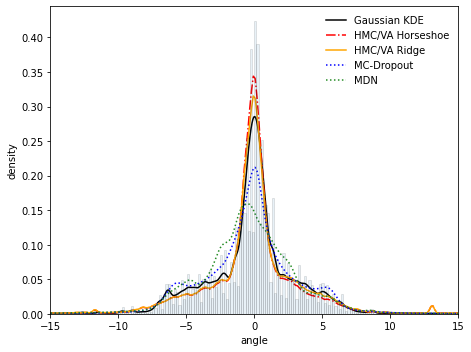

In [21]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.plot(support, density_gauss, color = 'black', label = 'Gaussian KDE')
ax.hist(true_y, bins=500, density=True,
        zorder=5, edgecolor='k', alpha=0.1)
ax.plot(grid, va_horse_av_den, color = 'red', linestyle= '-.', label = 'HMC/VA Horseshoe')
ax.plot(grid, va_ridge_av_den, color = 'orange', label = 'HMC/VA Ridge')
ax.plot(grid, mc_dropout_av_dens, color = 'blue', label = 'MC-Dropout', linestyle= ':')
ax.plot(grid, mdn_av_dens, color = 'forestgreen', label = 'MDN', linestyle= ':')
#ax.plot(grid, hmc_ridge['av_density'], color = 'orange', label = 'HMC Ridge', linestyle = '-.')
#ax.plot(grid, hmc_horse_av_den, color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.set_xlim(-15,15)
ax.legend()
plt.legend(framealpha=0.0)
plt.xlabel('angle')
plt.ylabel('density')
fig.tight_layout(rect=[0.05, 0, 1, 1])
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/marginal_calibration_cil.png') 

## Marginal Calibration 2

In [16]:
# get cdfs
def f_integral(i):
        return(integrate.trapz(va_horse_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
va_horse_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(hmc_horse_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
hmc_horse_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(va_ridge_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
va_ridge_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(hmc_ridge_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
hmc_ridge_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(hmc_ridge_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
hmc_ridge_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(mc_dropout_av_dens[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
mc_dropout_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(mdn_av_dens[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
mdn_cdf = np.cumsum(np.array(probs))

In [9]:
Gt = []
for i in tqdm(grid):
    Gt.append(sum(x <= i for x in true_y))
Gt = np.array(Gt)/len(true_y)

100%|██████████| 750/750 [05:58<00:00,  2.09it/s]


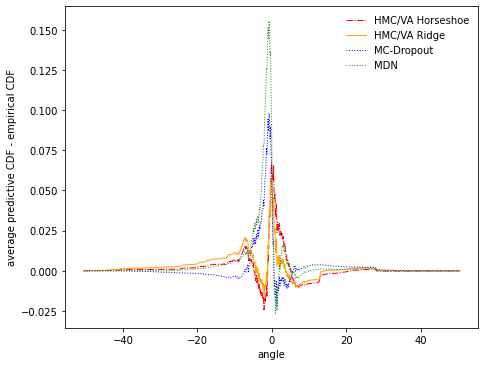

In [17]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(grid, va_horse_cdf - Gt,  color = 'red', label = 'HMC/VA Horseshoe', linestyle = '-.', linewidth = 1)
ax.plot(grid, va_ridge_cdf - Gt, color = 'orange', label = 'HMC/VA Ridge', linewidth = 1)
ax.plot(grid, mc_dropout_cdf - Gt, color = 'blue', label = 'MC-Dropout', linewidth = 1, linestyle = ':')
ax.plot(grid, mdn_cdf - Gt, color = 'forestgreen', label = 'MDN', linewidth = 1, linestyle = ':')
#ax.plot(grid, hmc_horse_cdf - Gt,  color = 'blue', label = 'VA/Horseshoe', linestyle = '-.', linewidth = 1)
#ax.plot(grid, hmc_ridge_cdf - Gt, color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.legend()
plt.legend(framealpha=0.0)
fig.tight_layout(rect=[0.05, 0, 1, 1])
plt.xlabel('angle')
plt.autoscale()
plt.ylabel('average predictive CDF - empirical CDF')
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/marginal_calibration2_cil.png') 

## Probability Calibration

In [18]:
help_grid = [find_closest_element(grid_i, support) for grid_i in grid]

In [19]:
# true density
grid2 = np.array([i for i in range(0, support.shape[0])])
def f_integral(i):
    return(integrate.trapz(density_gauss[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, grid2)
cdf = np.cumsum(np.array(probs))

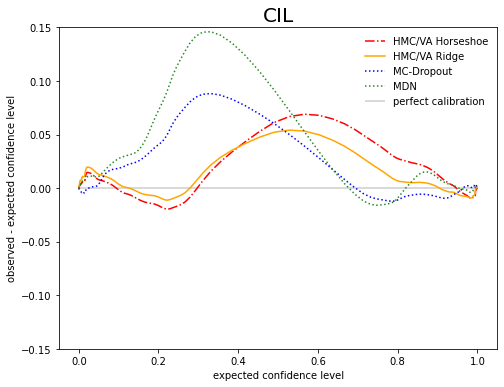

In [26]:
# plot like in Klein Paper
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
#ax.plot(cdf, cdf_va- cdf, color = 'red', label = 'VA/Horseshoe')
ax.hlines(0, 0, 1, color = 'black', label ='perfect calibration', alpha = 0.2)
ax.plot(cdf[help_grid], va_horse_cdf - cdf[help_grid], color = 'red', linestyle= '-.', label = 'HMC/VA Horseshoe')
ax.plot(cdf[help_grid], va_ridge_cdf - cdf[help_grid], color = 'orange', label = 'HMC/VA Ridge') #*0.9292
ax.plot(cdf[help_grid], mc_dropout_cdf - cdf[help_grid], color = 'blue', label = 'MC-Dropout', linestyle= ':') #*0.9292
ax.plot(cdf[help_grid], mdn_cdf - cdf[help_grid], color = 'forestgreen', label = 'MDN', linestyle= ':') #*0.9292
ax.legend()
plt.legend(framealpha=0.0)
plt.tight_layout()
plt.autoscale()
plt.ylim(-.15,.15)
plt.title('CIL', size = 20)
plt.xlabel('expected confidence level')
plt.ylabel('observed - expected confidence level')
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/prob_calibration_cil.png') 

In [ ]:
# plot like in Klein Paper
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
#ax.plot(cdf, cdf_va- cdf, color = 'red', label = 'VA/Horseshoe')
ax.plot(cdf[help_grid], np.abs(va_horse_cdf - cdf[help_grid]), color = 'red', linestyle= '-.', label = 'HMC/VA Horseshoe')
ax.plot(cdf[help_grid], np.abs(va_ridge_cdf - cdf[help_grid]), color = 'orange', label = 'HMC/VA Ridge') #*0.9292
ax.plot(cdf[help_grid], np.abs(mc_dropout_cdf - cdf[help_grid]), color = 'blue', label = 'MC-Dropout', linestyle= ':') #*0.9292
ax.plot(cdf[help_grid], np.abs(mdn_cdf - cdf[help_grid]), color = 'forestgreen', label = 'MDN', linestyle= ':') #*0.9292ax.legend()
plt.legend(framealpha=0.0)
#plt.tight_layout()
plt.autoscale()
#plt.ylim(-.2,.2)
plt.xlabel('expected confidence level')
plt.ylabel('observed - expected confidence level')
#plt.savefig('../../../../data/commaai/calibration/marginal_calibration/prob_calibration_cil.png') 